In [1]:
%cd ..

/mnt/c/Users/maxli/OneDrive - Van Oord/Documents/thesis/code


In [2]:
import pandas as pd
import geopandas as gpd
from glob import glob
import seaborn as sns
from atl_module.plotting import error_lidar_pt_vs_truth_pt,plot_photon_map,plot_tracklines_overview
from sklearn.metrics import r2_score

In [3]:
aoidflist = []
for aoifile in glob('../data/test_sites/oahu*/AOI.gpkg'):
    # get the name of each site
    sitename = aoifile.split('/')[3]
    df = gpd.read_file(aoifile)
    df['site']=sitename
    aoidflist.append(df)
    
aoi_combined = pd.concat(aoidflist)


In [4]:
tracklines_dflist = [gpd.read_file(file) for file in glob('../data/test_sites/oahu*/tracklines')]
tracklines_combined = pd.concat(tracklines_dflist).reset_index()

In [17]:
dflist = [gpd.read_file(file) for file in glob('../data/test_sites/oahu*/all_bathy_pts.gpkg')]
df = pd.concat(dflist)
# .reset_index().dropna()

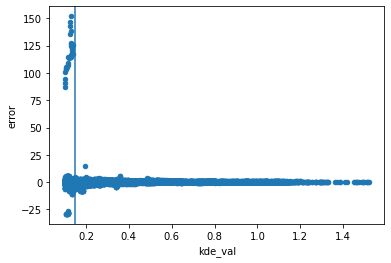

In [24]:
ax = df.plot.scatter(x='kde_val',y='error')
ax.axvline(0.15)

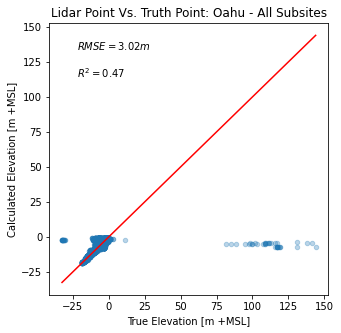

In [6]:
errordict = {'RMSE':df.error.pow(2).mean()**0.5,'R2 Score':r2_score(df.true_elevation,df.sf_elev_MSL)}
ax = error_lidar_pt_vs_truth_pt(df,'Oahu - All Subsites',errordict)
ax.get_figure().savefig('../document/figures/Oahu_combined_lidar_estimated_vs_truth.jpg')

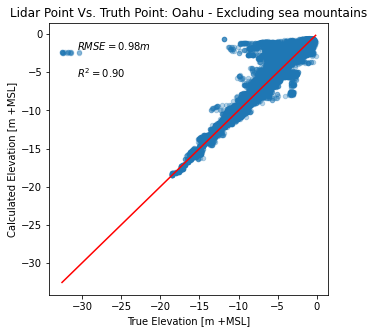

In [7]:
df = df[df.true_elevation<0]
errordict = {'RMSE':df.error.pow(2).mean()**0.5,'R2 Score':r2_score(df.true_elevation,df.sf_elev_MSL)}
ax= error_lidar_pt_vs_truth_pt(df,'Oahu - Excluding sea mountains',errordict)
ax.get_figure().savefig('../document/figures/Oahu_combined_mountains_removed_lidar_estimated_vs_truth.jpg')

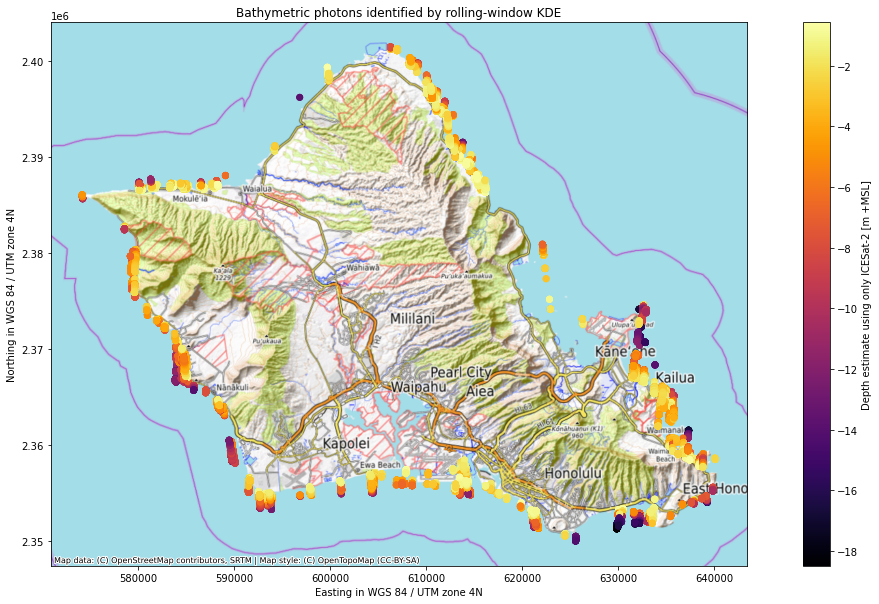

In [21]:
ax = plot_photon_map(df)

<AxesSubplot:title={'center':'Study site and tracklines'}, xlabel='Easting in WGS 84', ylabel='Northing in WGS 84'>

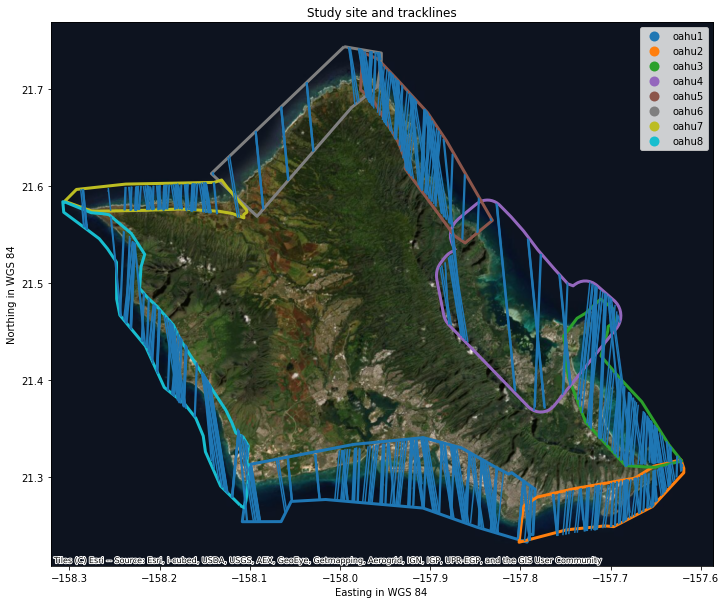

In [9]:
trackax = plot_tracklines_overview(tracklines_combined)
aoi_combined.plot(figsize=(10,10),column='site',categorical=True,legend=True,facecolor="none",lw=3,ax=trackax)